In [1]:
import cv2
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline  

from heatmap_estimator import HeatmapEstimator
from projection_dataset import ProjectionDataset
%load_ext autoreload
%autoreload 2

In [2]:
dataset_dir = "../data/projections"
plane = "XY" # Other planes: YZ and ZX
model_path = "../models/" + plane + ".pth"

In [3]:
train_subjects = ["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8"]
train_gestures = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "I", "IP", "L", "MP", "RP", "T", "TIP", "Y"]
train_dataset = ProjectionDataset(dataset_dir, train_subjects, train_gestures, plane, False)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)

In [4]:
val_subjects = ["P0"]
val_gestures = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "I", "IP", "L", "MP", "RP", "T", "TIP", "Y"]
val_dataset = ProjectionDataset(dataset_dir, val_subjects, val_gestures, plane, False)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)

[]

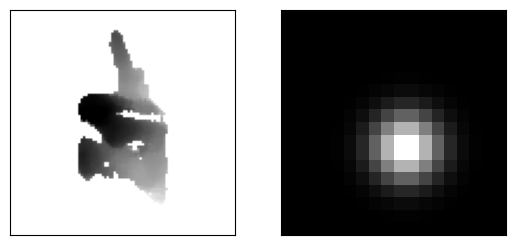

In [19]:
# Visualize sample
image, heatmap_gt = next(iter(val_dataloader))

fig, (plt1, plt2) = plt.subplots(1, 2)

plt1.imshow(torch.squeeze(image[23], 0).numpy(), cmap='gray', vmin=0, vmax=1)
plt1.set_xticks([])
plt1.set_yticks([])

heatmap_max = np.max(torch.squeeze(heatmap_gt[22][0], 0).numpy())
plt2.imshow(torch.squeeze(heatmap_gt[22][0], 0).numpy() / heatmap_max, cmap='gray', vmin=0, vmax=1)
plt2.set_xticks([])
plt2.set_yticks([])

In [6]:
# Load the model
device = 'cuda'
model = HeatmapEstimator().to(device)

In [7]:
# Configure the optimizer and criterion
optimizer = torch.optim.SGD(model.parameters(), lr=0.2, momentum=0.9, weight_decay=0.0005)
criterion = torch.nn.MSELoss()

Computing epoch 0
Minibatch 0 Loss = 0.00145605
Minibatch 50 Loss = 0.00012735
Minibatch 100 Loss = 0.00011501
Minibatch 150 Loss = 0.00010561
Minibatch 200 Loss = 0.00009903
Minibatch 250 Loss = 0.00009363
Plotting sample validation figures


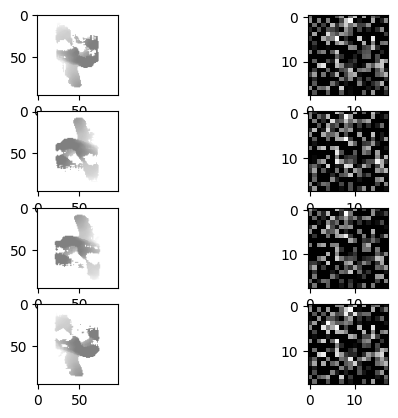

Epoch 0: Training Loss = 0.00014230, Validation Loss = 0.00009165
Computing epoch 1
Minibatch 0 Loss = 0.00009205
Minibatch 50 Loss = 0.00008733
Minibatch 100 Loss = 0.00008437
Minibatch 150 Loss = 0.00008133
Minibatch 200 Loss = 0.00007863
Minibatch 250 Loss = 0.00007686
Epoch 1: Training Loss = 0.00008291, Validation Loss = 0.00007603
Computing epoch 2
Minibatch 0 Loss = 0.00007610
Minibatch 50 Loss = 0.00007462
Minibatch 100 Loss = 0.00007324
Minibatch 150 Loss = 0.00007214
Minibatch 200 Loss = 0.00007049
Minibatch 250 Loss = 0.00007008
Epoch 2: Training Loss = 0.00007258, Validation Loss = 0.00006964
Computing epoch 3
Minibatch 0 Loss = 0.00006985
Minibatch 50 Loss = 0.00006899
Minibatch 100 Loss = 0.00006848
Minibatch 150 Loss = 0.00006800
Minibatch 200 Loss = 0.00006772
Minibatch 250 Loss = 0.00006716
Epoch 3: Training Loss = 0.00006817, Validation Loss = 0.00006680
Computing epoch 4
Minibatch 0 Loss = 0.00006700
Minibatch 50 Loss = 0.00006649
Minibatch 100 Loss = 0.00006632
Mini

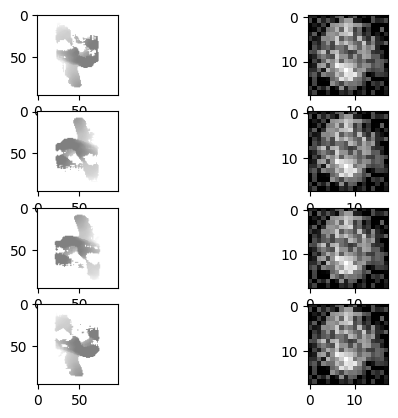

Epoch 5: Training Loss = 0.00006515, Validation Loss = 0.00006476
Computing epoch 6
Minibatch 0 Loss = 0.00006505
Minibatch 50 Loss = 0.00006491
Minibatch 100 Loss = 0.00006456
Minibatch 150 Loss = 0.00006479
Minibatch 200 Loss = 0.00006448
Minibatch 250 Loss = 0.00006450
Epoch 6: Training Loss = 0.00006463, Validation Loss = 0.00006440
Computing epoch 7
Minibatch 0 Loss = 0.00006434
Minibatch 50 Loss = 0.00006452
Minibatch 100 Loss = 0.00006452
Minibatch 150 Loss = 0.00006434
Minibatch 200 Loss = 0.00006444
Minibatch 250 Loss = 0.00006425
Epoch 7: Training Loss = 0.00006434, Validation Loss = 0.00006419
Computing epoch 8
Minibatch 0 Loss = 0.00006457
Minibatch 50 Loss = 0.00006434
Minibatch 100 Loss = 0.00006432
Minibatch 150 Loss = 0.00006383
Minibatch 200 Loss = 0.00006441
Minibatch 250 Loss = 0.00006414
Epoch 8: Training Loss = 0.00006418, Validation Loss = 0.00006407
Computing epoch 9
Minibatch 0 Loss = 0.00006414
Minibatch 50 Loss = 0.00006405
Minibatch 100 Loss = 0.00006393
Mini

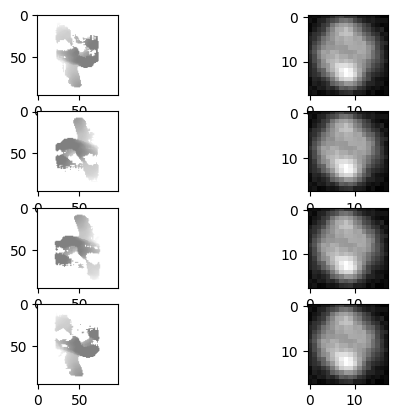

Epoch 10: Training Loss = 0.00006401, Validation Loss = 0.00006394
Computing epoch 11
Minibatch 0 Loss = 0.00006413
Minibatch 50 Loss = 0.00006406
Minibatch 100 Loss = 0.00006384
Minibatch 150 Loss = 0.00006392
Minibatch 200 Loss = 0.00006393
Minibatch 250 Loss = 0.00006367
Epoch 11: Training Loss = 0.00006397, Validation Loss = 0.00006391
Computing epoch 12
Minibatch 0 Loss = 0.00006404
Minibatch 50 Loss = 0.00006368
Minibatch 100 Loss = 0.00006393
Minibatch 150 Loss = 0.00006369
Minibatch 200 Loss = 0.00006385
Minibatch 250 Loss = 0.00006391
Epoch 12: Training Loss = 0.00006394, Validation Loss = 0.00006389
Computing epoch 13
Minibatch 0 Loss = 0.00006408
Minibatch 50 Loss = 0.00006371
Minibatch 100 Loss = 0.00006401
Minibatch 150 Loss = 0.00006361
Minibatch 200 Loss = 0.00006401
Minibatch 250 Loss = 0.00006396
Epoch 13: Training Loss = 0.00006393, Validation Loss = 0.00006387
Computing epoch 14
Minibatch 0 Loss = 0.00006408
Minibatch 50 Loss = 0.00006378
Minibatch 100 Loss = 0.00006

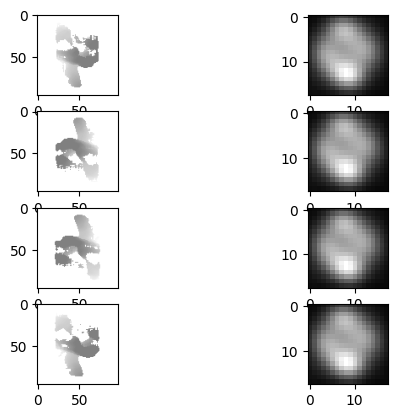

Epoch 15: Training Loss = 0.00006390, Validation Loss = 0.00006386
Computing epoch 16
Minibatch 0 Loss = 0.00006363
Minibatch 50 Loss = 0.00006384
Minibatch 100 Loss = 0.00006407
Minibatch 150 Loss = 0.00006393
Minibatch 200 Loss = 0.00006366
Minibatch 250 Loss = 0.00006421
Epoch 16: Training Loss = 0.00006390, Validation Loss = 0.00006385
Computing epoch 17
Minibatch 0 Loss = 0.00006375
Minibatch 50 Loss = 0.00006354
Minibatch 100 Loss = 0.00006396
Minibatch 150 Loss = 0.00006431
Minibatch 200 Loss = 0.00006381
Minibatch 250 Loss = 0.00006377
Epoch 17: Training Loss = 0.00006389, Validation Loss = 0.00006385
Computing epoch 18
Minibatch 0 Loss = 0.00006373
Minibatch 50 Loss = 0.00006385
Minibatch 100 Loss = 0.00006419
Minibatch 150 Loss = 0.00006393
Minibatch 200 Loss = 0.00006408
Minibatch 250 Loss = 0.00006394
Epoch 18: Training Loss = 0.00006389, Validation Loss = 0.00006385
Computing epoch 19
Minibatch 0 Loss = 0.00006413
Minibatch 50 Loss = 0.00006405
Minibatch 100 Loss = 0.00006

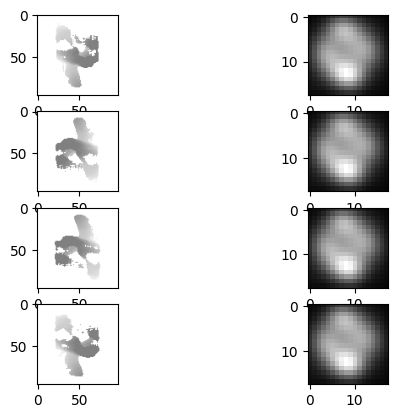

Epoch 20: Training Loss = 0.00006389, Validation Loss = 0.00006385
Computing epoch 21
Minibatch 0 Loss = 0.00006382
Minibatch 50 Loss = 0.00006375
Minibatch 100 Loss = 0.00006373
Minibatch 150 Loss = 0.00006380
Minibatch 200 Loss = 0.00006379
Minibatch 250 Loss = 0.00006363
Epoch 21: Training Loss = 0.00006389, Validation Loss = 0.00006385
Computing epoch 22
Minibatch 0 Loss = 0.00006385
Minibatch 50 Loss = 0.00006399
Minibatch 100 Loss = 0.00006399
Minibatch 150 Loss = 0.00006402
Minibatch 200 Loss = 0.00006401
Minibatch 250 Loss = 0.00006372
Epoch 22: Training Loss = 0.00006388, Validation Loss = 0.00006385
Computing epoch 23
Minibatch 0 Loss = 0.00006368
Minibatch 50 Loss = 0.00006404
Minibatch 100 Loss = 0.00006383
Minibatch 150 Loss = 0.00006386
Minibatch 200 Loss = 0.00006422
Minibatch 250 Loss = 0.00006369
Epoch 23: Training Loss = 0.00006389, Validation Loss = 0.00006385
Computing epoch 24
Minibatch 0 Loss = 0.00006377
Minibatch 50 Loss = 0.00006387
Minibatch 100 Loss = 0.00006

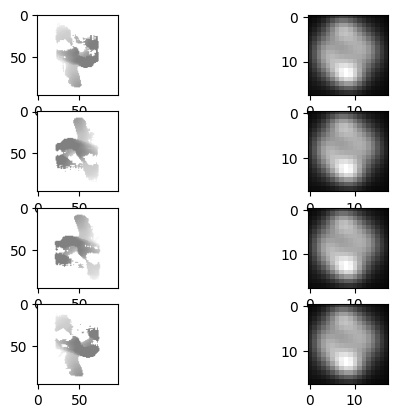

Epoch 25: Training Loss = 0.00006388, Validation Loss = 0.00006385
Computing epoch 26
Minibatch 0 Loss = 0.00006389
Minibatch 50 Loss = 0.00006381
Minibatch 100 Loss = 0.00006396
Minibatch 150 Loss = 0.00006389
Minibatch 200 Loss = 0.00006392
Minibatch 250 Loss = 0.00006393
Epoch 26: Training Loss = 0.00006389, Validation Loss = 0.00006384
Computing epoch 27
Minibatch 0 Loss = 0.00006393
Minibatch 50 Loss = 0.00006368
Minibatch 100 Loss = 0.00006380
Minibatch 150 Loss = 0.00006402
Minibatch 200 Loss = 0.00006396
Minibatch 250 Loss = 0.00006385
Epoch 27: Training Loss = 0.00006389, Validation Loss = 0.00006384
Computing epoch 28
Minibatch 0 Loss = 0.00006424
Minibatch 50 Loss = 0.00006396
Minibatch 100 Loss = 0.00006390
Minibatch 150 Loss = 0.00006364
Minibatch 200 Loss = 0.00006393
Minibatch 250 Loss = 0.00006326
Epoch 28: Training Loss = 0.00006389, Validation Loss = 0.00006385
Computing epoch 29
Minibatch 0 Loss = 0.00006390
Minibatch 50 Loss = 0.00006374
Minibatch 100 Loss = 0.00006

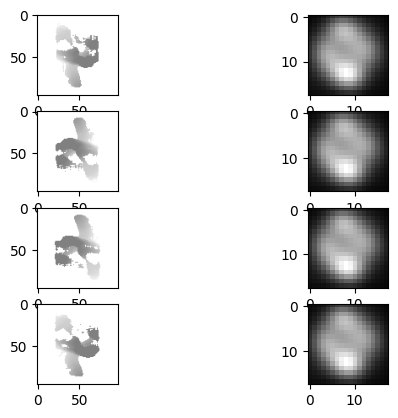

Epoch 30: Training Loss = 0.00006388, Validation Loss = 0.00006384
Computing epoch 31
Minibatch 0 Loss = 0.00006382
Minibatch 50 Loss = 0.00006380
Minibatch 100 Loss = 0.00006383
Minibatch 150 Loss = 0.00006357
Minibatch 200 Loss = 0.00006374
Minibatch 250 Loss = 0.00006385
Epoch 31: Training Loss = 0.00006388, Validation Loss = 0.00006384
Computing epoch 32
Minibatch 0 Loss = 0.00006424
Minibatch 50 Loss = 0.00006377
Minibatch 100 Loss = 0.00006394
Minibatch 150 Loss = 0.00006377
Minibatch 200 Loss = 0.00006396
Minibatch 250 Loss = 0.00006406
Epoch 32: Training Loss = 0.00006388, Validation Loss = 0.00006385
Computing epoch 33
Minibatch 0 Loss = 0.00006411
Minibatch 50 Loss = 0.00006406
Minibatch 100 Loss = 0.00006405
Minibatch 150 Loss = 0.00006396
Minibatch 200 Loss = 0.00006371
Minibatch 250 Loss = 0.00006397
Epoch 33: Training Loss = 0.00006389, Validation Loss = 0.00006385
Computing epoch 34
Minibatch 0 Loss = 0.00006383
Minibatch 50 Loss = 0.00006396
Minibatch 100 Loss = 0.00006

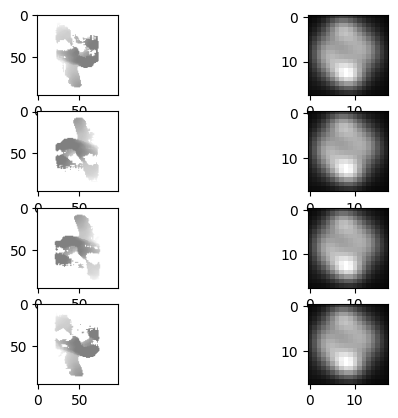

Epoch 35: Training Loss = 0.00006388, Validation Loss = 0.00006385
Computing epoch 36
Minibatch 0 Loss = 0.00006379
Minibatch 50 Loss = 0.00006403
Minibatch 100 Loss = 0.00006347
Minibatch 150 Loss = 0.00006366
Minibatch 200 Loss = 0.00006381
Minibatch 250 Loss = 0.00006358
Epoch 36: Training Loss = 0.00006389, Validation Loss = 0.00006385
Computing epoch 37
Minibatch 0 Loss = 0.00006410
Minibatch 50 Loss = 0.00006372
Minibatch 100 Loss = 0.00006401
Minibatch 150 Loss = 0.00006379
Minibatch 200 Loss = 0.00006379
Minibatch 250 Loss = 0.00006384
Epoch 37: Training Loss = 0.00006389, Validation Loss = 0.00006384
Computing epoch 38
Minibatch 0 Loss = 0.00006399
Minibatch 50 Loss = 0.00006377
Minibatch 100 Loss = 0.00006399
Minibatch 150 Loss = 0.00006387
Minibatch 200 Loss = 0.00006369
Minibatch 250 Loss = 0.00006385
Epoch 38: Training Loss = 0.00006388, Validation Loss = 0.00006384
Computing epoch 39
Minibatch 0 Loss = 0.00006407
Minibatch 50 Loss = 0.00006383
Minibatch 100 Loss = 0.00006

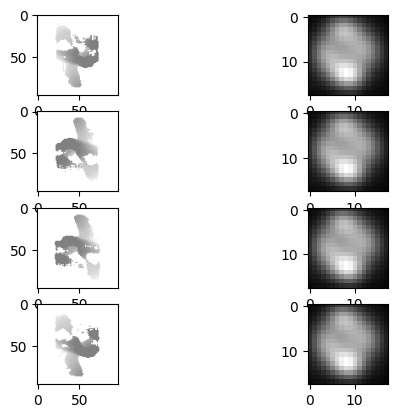

Epoch 40: Training Loss = 0.00006388, Validation Loss = 0.00006384
Computing epoch 41
Minibatch 0 Loss = 0.00006369
Minibatch 50 Loss = 0.00006396
Minibatch 100 Loss = 0.00006373
Minibatch 150 Loss = 0.00006384
Minibatch 200 Loss = 0.00006389
Minibatch 250 Loss = 0.00006392
Epoch 41: Training Loss = 0.00006389, Validation Loss = 0.00006384
Computing epoch 42
Minibatch 0 Loss = 0.00006377
Minibatch 50 Loss = 0.00006389
Minibatch 100 Loss = 0.00006417
Minibatch 150 Loss = 0.00006410
Minibatch 200 Loss = 0.00006386
Minibatch 250 Loss = 0.00006394
Epoch 42: Training Loss = 0.00006389, Validation Loss = 0.00006384
Computing epoch 43
Minibatch 0 Loss = 0.00006421
Minibatch 50 Loss = 0.00006375
Minibatch 100 Loss = 0.00006387
Minibatch 150 Loss = 0.00006402
Minibatch 200 Loss = 0.00006430
Minibatch 250 Loss = 0.00006371
Epoch 43: Training Loss = 0.00006388, Validation Loss = 0.00006384
Computing epoch 44
Minibatch 0 Loss = 0.00006410
Minibatch 50 Loss = 0.00006410
Minibatch 100 Loss = 0.00006

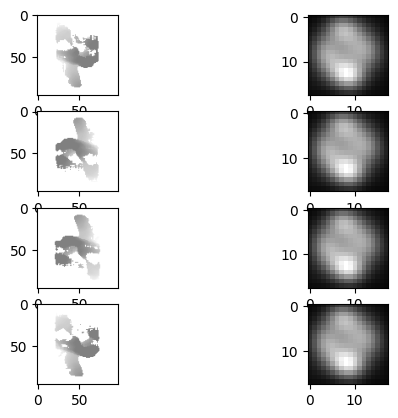

Epoch 45: Training Loss = 0.00006388, Validation Loss = 0.00006384
Computing epoch 46
Minibatch 0 Loss = 0.00006353
Minibatch 50 Loss = 0.00006390
Minibatch 100 Loss = 0.00006382
Minibatch 150 Loss = 0.00006412
Minibatch 200 Loss = 0.00006378
Minibatch 250 Loss = 0.00006378
Epoch 46: Training Loss = 0.00006389, Validation Loss = 0.00006385
Computing epoch 47
Minibatch 0 Loss = 0.00006395
Minibatch 50 Loss = 0.00006412
Minibatch 100 Loss = 0.00006415
Minibatch 150 Loss = 0.00006386
Minibatch 200 Loss = 0.00006410
Minibatch 250 Loss = 0.00006401
Epoch 47: Training Loss = 0.00006389, Validation Loss = 0.00006384
Computing epoch 48
Minibatch 0 Loss = 0.00006402
Minibatch 50 Loss = 0.00006394
Minibatch 100 Loss = 0.00006393
Minibatch 150 Loss = 0.00006413
Minibatch 200 Loss = 0.00006401
Minibatch 250 Loss = 0.00006407
Epoch 48: Training Loss = 0.00006388, Validation Loss = 0.00006384
Computing epoch 49
Minibatch 0 Loss = 0.00006392
Minibatch 50 Loss = 0.00006392
Minibatch 100 Loss = 0.00006

In [8]:
# Main training loop
epochs = 50
train_loss_over_epochs = []
val_loss_over_epochs = []
for epoch in range(epochs):
    print("Computing epoch", epoch)
    minibatch = 0

    train_loss = 0
    for lcn, heatmaps in train_dataloader:    
        optimizer.zero_grad()
        
        lcn = lcn.type(torch.FloatTensor).to(device)
        lcn = torch.unsqueeze(lcn, dim=1)
        pred = model(lcn)
        
        heatmaps = heatmaps.type(torch.FloatTensor).to(device)
        loss = criterion(pred, heatmaps)
        
        loss.backward()
        optimizer.step()
        
        if (minibatch % 50 == 0):
            print("Minibatch {} Loss = {:.8f}".format(minibatch, loss.item()))
        minibatch += 1    
            
        train_loss += loss.cpu().item()
    train_loss /= len(train_dataloader)
    train_loss_over_epochs.append(train_loss)     
    
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for lcn, heatmaps in val_dataloader:
            lcn = lcn.type(torch.FloatTensor).to(device)
            lcn = torch.unsqueeze(lcn, dim=1)
            pred = model(lcn)

            heatmaps = heatmaps.type(torch.FloatTensor).to(device)
            
            if ((val_loss == 0) and (epoch % 5 == 0)):
                print("Plotting sample validation figures")
                fig, axes = plt.subplots(4, 2)
                for i in range(4):
                    axes[i, 0].imshow(torch.squeeze(image[i], 0).numpy(), cmap='gray', vmin=-1, vmax=1)
                    
                    im_max = np.max(pred[i][0].cpu().numpy())
                    axes[i, 1].imshow(torch.squeeze(pred[i][0], 0).cpu().numpy() / im_max, cmap='gray', vmin=0, vmax=1)
                plt.show()
            
            loss = criterion(pred, heatmaps)
            val_loss += loss.cpu().item()
    val_loss /= len(val_dataloader)
    val_loss_over_epochs.append(val_loss)
    
    if (epoch + 1 % 10 == 0):
        for g in optimizer.param_groups:
            g['lr'] /= 2
        
        
    
    print("Epoch {}: Training Loss = {:.8f}, Validation Loss = {:.8f}".format(epoch, train_loss, val_loss))

In [ ]:
# Plot training and validation loss
plt.subplot(2, 1, 1)
plt.ylabel('Loss')
plt.plot(np.arange(epochs), train_loss_over_epochs, color='red', label='train')
plt.plot(np.arange(epochs), val_loss_over_epochs, color='blue', label='val')
plt.title('Loss per Epoch')
plt.xticks(np.arange(epochs, dtype=int))
plt.locator_params(axis='x', nbins=10)
plt.grid(True)
plt.legend()
plt.show()

In [10]:
torch.save(model.state_dict(), model_path)

## Evaluation

In [11]:
model = HeatmapEstimator()
model.load_state_dict(torch.load(model_path))
model = model.to(device)

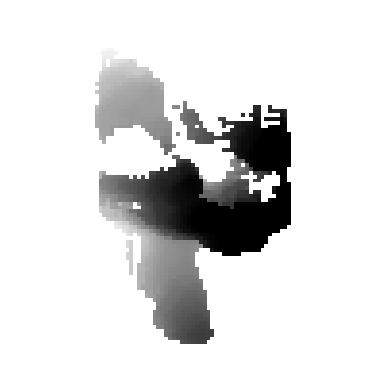

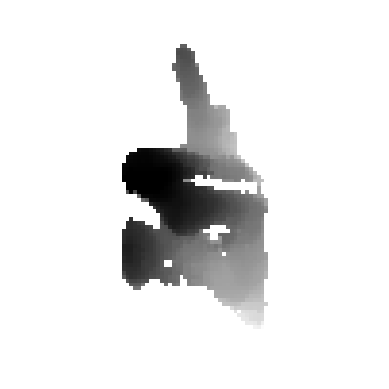

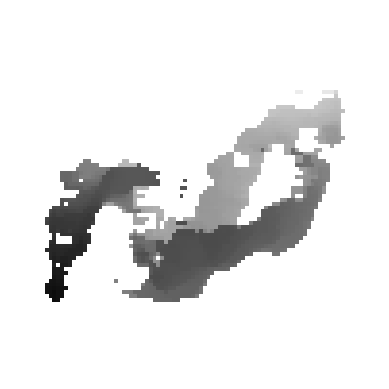

In [18]:
# Visualize sample
image, heatmap_gt = next(iter(val_dataloader))

plt.imshow(torch.squeeze(image[0], 0).numpy(), cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.show()

plt.imshow(torch.squeeze(image[23], 0).numpy(), cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.show()

plt.imshow(torch.squeeze(image[50], 0).numpy(), cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.show()

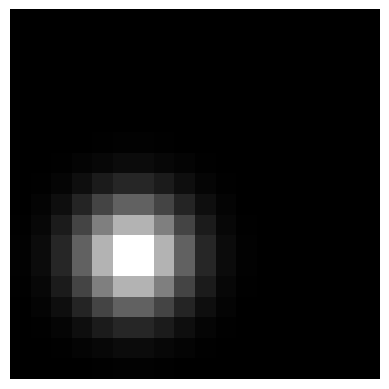

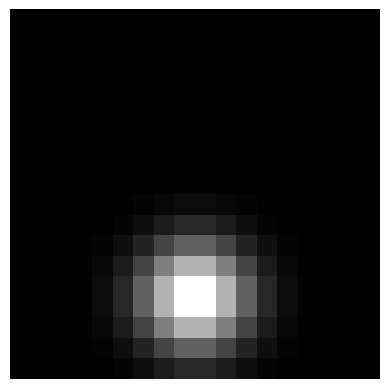

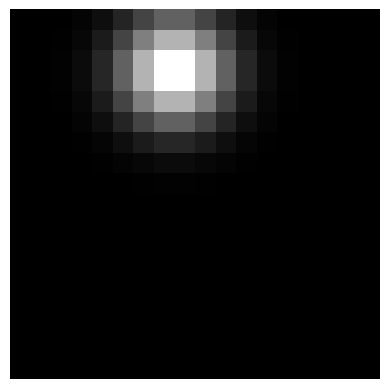

In [21]:
im_max = np.max(heatmap_gt[0][2].cpu().numpy())
plt.imshow(torch.squeeze(heatmap_gt[0][2], 0).numpy() / im_max, cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.show()

im_max = np.max(heatmap_gt[23][0].cpu().numpy())
plt.imshow(torch.squeeze(heatmap_gt[23][0], 0).numpy() / im_max, cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.show()

im_max = np.max(heatmap_gt[50][0].cpu().numpy())
plt.imshow(torch.squeeze(heatmap_gt[50][0], 0).numpy() / im_max, cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.show()

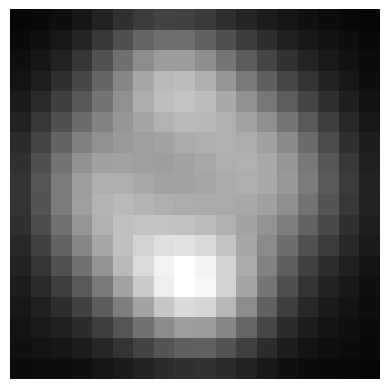

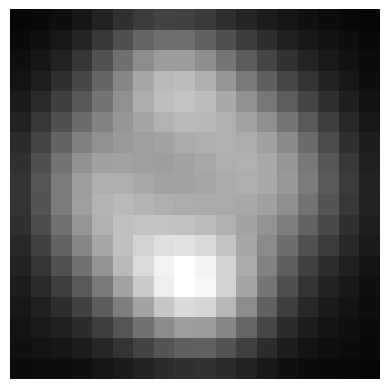

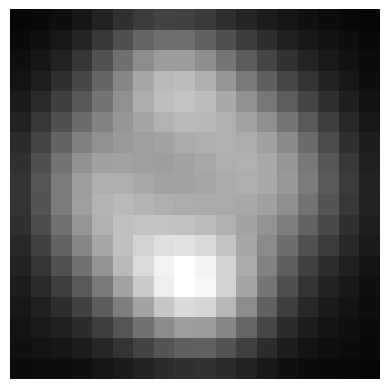

In [22]:
image = torch.unsqueeze(image.type(torch.FloatTensor).to(device), dim=1)
model.eval()
with torch.no_grad():
    pred = model(image)
    
    im_max = np.max(pred[0][0].cpu().numpy())
    plt.imshow(pred[0][0].cpu().numpy() / im_max, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.show()
    
    im_max = np.max(pred[23][0].cpu().numpy())
    plt.imshow(pred[23][0].cpu().numpy() / im_max, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.show()
    
    im_max = np.max(pred[50][0].cpu().numpy())
    plt.imshow(pred[50][0].cpu().numpy() / im_max, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.show()